# Inspecting the Independent Variables

The goal is to select the best predictor variables, i.e., those that most effectively distinguish between vegetation types.

The data are examined using the three available label sets. Each set has a **different number of labels**.

> Note: The `aspect` predictor has not been used.

In [1]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from matplotlib import pyplot as plt # type: ignore
from matplotlib.patches import Patch
from pathlib import Path
import numpy as np # type: ignore
import pandas as pd # type: ignore
import geopandas as gpd # type: ignore

In [2]:
ROOT = Path.cwd().resolve().parent

dataset = gpd.read_file(Path(ROOT, "results/dataset.csv"))
label_codes = pd.read_csv(Path(ROOT, "data/labels/label_codes.csv"))

Join the table of predictors with the table of label names representing the classified vegetation types.

In [3]:
# Try to convert stringified numeric columns back to numeric
for col in dataset.select_dtypes(include="object").columns:
    try:
        dataset[col] = pd.to_numeric(dataset[col])
    except:
        pass

# Keep 'code_ifn' out (to avoid dropping valid data via dropna)
label_codes = label_codes.loc[:, label_codes.columns != 'code_ifn']
dataset = dataset.join(label_codes.set_index("code_v1"), on="ESPE")

The notebook includes several graphics. These graphics can be saved in the directory specified by the `graphics_path` variable.

In [4]:
graphics_path = Path(ROOT, "figures")

## Data Inspection

First, verify that the predictor variables are in a valid numerical format.

In [5]:
global_pred = ["aspect", "dem", "shadow", "slope", "acibasi"]
pred_vars = (
    dataset.columns.str.endswith("summerlong")
    | dataset.columns.isin(global_pred)
)

In [6]:
dataset.loc[:, pred_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14202 entries, 0 to 14201
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   coastal_summerlong  13436 non-null  float64
 1   blue_summerlong     13445 non-null  float64
 2   green_summerlong    13481 non-null  float64
 3   red_summerlong      13477 non-null  float64
 4   nir_summerlong      13481 non-null  float64
 5   swir1_summerlong    13481 non-null  float64
 6   swir2_summerlong    13477 non-null  float64
 7   aspect              14202 non-null  float64
 8   dem                 14202 non-null  float64
 9   shadow              14202 non-null  float64
 10  slope               14202 non-null  float64
 11  acibasi             14202 non-null  float64
dtypes: float64(12)
memory usage: 1.3 MB


All variables have the correct data type. However, some columns contain invalid values:
  
- **aspect**: Values below 0 and above 360 are invalid.  
- **acibasi**: The value `-9999` corresponds to missing data.
- **slope**: Negative values should not exist.  

For this reason, values below zero are transformed to `NaN`.
This ensures that rows can be removed later if the corresponding dataset version makes use of the predictor variable.

In [7]:
dataset.loc[:, pred_vars].describe()

,coastal_summerlong,blue_summerlong,green_summerlong,red_summerlong,nir_summerlong,swir1_summerlong,swir2_summerlong,aspect,dem,shadow,slope,acibasi
count,13436.000000,13445.000000,13481.000000,13477.000000,13481.000000,13481.000000,13477.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000
mean,806.904158,931.635621,1355.431700,1644.659790,2861.508975,3170.518210,2358.733456,104.794492,835.063653,171.082031,15.125570,-1662.114209
std,473.138059,548.427039,700.077407,934.190585,716.522010,1326.401539,1204.525536,885.795660,345.291369,41.588180,9.898592,3723.773341
min,4.000000,8.000000,38.000000,65.000000,117.000000,125.000000,158.000000,-9999.000000,108.000000,0.000000,-0.352233,-9999.000000
25%,393.000000,447.000000,722.625000,774.000000,2281.000000,1973.000000,1259.000000,99.240776,546.000000,148.000000,7.962305,1.000000
50%,752.000000,873.000000,1295.750000,1607.000000,2766.666700,3210.000000,2390.500000,186.571564,911.000000,179.000000,13.858310,1.000000
75%,1166.425000,1352.000000,1907.500000,2413.000000,3378.500000,4299.333500,3345.500000,257.352417,1067.000000,198.000000,20.754893,1.000000
max,3490.000000,3892.000000,4837.000000,5721.000000,6692.000000,8114.000000,6843.000000,549.714355,2838.000000,255.000000,79.123726,2.000000


In [8]:
# Make a copy to avoid modifying the original dataset in place
dat = dataset.copy()

# Replace values < 0 with 0 (nodata value) in the masked columns only
dat.loc[:, pred_vars] = (
    dat.loc[:, pred_vars]
    .where(dat.loc[:, pred_vars] >= 0, 0)
)

dat["aspect"] = dat["aspect"].where(dat["aspect"].le(360), 0)

> **Note:** Some columns without negative values use 0 as their minimum because missing values (`NA`) were replaced with 0.

In [9]:
dat.loc[:, pred_vars].describe()

,coastal_summerlong,blue_summerlong,green_summerlong,red_summerlong,nir_summerlong,swir1_summerlong,swir2_summerlong,aspect,dem,shadow,slope,acibasi
count,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000,14202.000000
mean,763.382923,881.977252,1286.619825,1560.701309,2716.237325,3009.558934,2238.322123,175.152063,835.063653,171.082031,15.125724,0.865512
std,494.985225,573.183966,744.154558,979.388097,939.126080,1467.810596,1283.101166,98.319848,345.291369,41.588180,9.898355,0.424343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,108.000000,0.000000,0.000000,0.000000
25%,347.500000,400.500000,664.333300,682.000000,2214.812500,1799.625000,1088.708350,93.475615,546.000000,148.000000,7.962305,1.000000
50%,698.000000,813.000000,1213.166700,1490.000000,2710.125000,3037.875000,2248.000000,182.684631,911.000000,179.000000,13.858310,1.000000
75%,1145.000000,1326.729150,1878.000000,2375.000000,3344.000000,4258.375000,3303.249975,252.397156,1067.000000,198.000000,20.754893,1.000000
max,3490.000000,3892.000000,4837.000000,5721.000000,6692.000000,8114.000000,6843.000000,359.809509,2838.000000,255.000000,79.123726,2.000000


In [10]:
dat.loc[:, pred_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14202 entries, 0 to 14201
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   coastal_summerlong  14202 non-null  float64
 1   blue_summerlong     14202 non-null  float64
 2   green_summerlong    14202 non-null  float64
 3   red_summerlong      14202 non-null  float64
 4   nir_summerlong      14202 non-null  float64
 5   swir1_summerlong    14202 non-null  float64
 6   swir2_summerlong    14202 non-null  float64
 7   aspect              14202 non-null  float64
 8   dem                 14202 non-null  float64
 9   shadow              14202 non-null  float64
 10  slope               14202 non-null  float64
 11  acibasi             14202 non-null  float64
dtypes: float64(12)
memory usage: 1.3 MB


In [11]:
# Remove columns with nodata values
dat = dat[(dat.loc[:, pred_vars] != 0).all(axis=1)]


In [12]:
dat.loc[:, pred_vars].describe()

,coastal_summerlong,blue_summerlong,green_summerlong,red_summerlong,nir_summerlong,swir1_summerlong,swir2_summerlong,aspect,dem,shadow,slope,acibasi
count,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000,11158.000000
mean,759.736303,872.429589,1264.413045,1524.351964,2792.416358,3047.963597,2221.902966,182.614124,925.297634,172.144022,16.459073,1.038537
std,477.368770,547.345181,673.703643,908.077475,708.818357,1337.474502,1185.457182,95.173074,280.897222,41.103247,9.569138,0.192498
min,4.000000,10.000000,168.000000,65.000000,617.000000,451.000000,158.000000,0.003486,108.000000,1.000000,0.000297,1.000000
25%,358.541665,412.000000,679.357125,708.000000,2232.000000,1848.125000,1136.000000,104.421780,721.000000,146.000000,9.681474,1.000000
50%,640.000000,736.875000,1114.000000,1335.583300,2649.500000,2873.000000,2092.125000,188.402496,970.000000,179.000000,15.023379,1.000000
75%,1131.000000,1295.000000,1791.666600,2292.000000,3286.458325,4236.150000,3239.916675,258.934395,1092.000000,201.000000,21.790399,1.000000
max,3490.000000,3892.000000,4837.000000,5721.000000,6692.000000,8114.000000,6843.000000,359.809509,2768.000000,255.000000,79.123726,2.000000


To obtain a more balanced dataset, most of the labels corresponding to sparse vegetation were removed, leaving a number of cases similar to that of the second most frequent label.

In [13]:
def bg_undersampling(df):
    """Perform a reduction in the very high bare ground number of labels"""
    X = df.drop(columns=['ESPE_rc'])
    y = df['ESPE_rc']

    # Find the sparse vegetation class
    max_clss = y.value_counts().idxmax()
    # Define the undersampler
    rus = RandomUnderSampler(
        sampling_strategy={max_clss: 800},
        random_state=42
    )

    # Apply undersampling
    X_resampled, y_resampled = rus.fit_resample(X, y)

    # Create new dataframe. This is mandatory to remove NA values in each
    # predictor set iteration and remove the ESPE codes related to them
    dataset = pd.concat([
        X_resampled.reset_index(drop=True),
        y_resampled.reset_index(drop=True)],
        axis=1
    )

    return dataset

dat = bg_undersampling(dat)

In [14]:
dat.loc[:, pred_vars].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5225 entries, 0 to 5224
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   blue_summerlong   5225 non-null   float64
 1   green_summerlong  5225 non-null   float64
 2   red_summerlong    5225 non-null   float64
 3   nir_summerlong    5225 non-null   float64
 4   swir1_summerlong  5225 non-null   float64
 5   swir2_summerlong  5225 non-null   float64
 6   aspect            5225 non-null   float64
 7   dem               5225 non-null   float64
 8   shadow            5225 non-null   float64
 9   slope             5225 non-null   float64
 10  acibasi           5225 non-null   float64
 11  code_v1_reclass   5225 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 490.0 KB


### Create NDVI

In [15]:
def ndvi(df, suffix):
    numerator = df[f"nir_{suffix}"] - df[f"red_{suffix}"]
    denominator = df[f"nir_{suffix}"] + df[f"red_{suffix}"]
    return numerator / denominator

dat["NDVI_summerlong"] = ndvi(dat, "summerlong")

## Versions

There are three different training datasets, or versions of the original dataset.

In [16]:
dat_queries = {1: "(source == 'Digitized') | (source == 'SIOSE')"}
dat_queries[2] = f"(FCC > 20) & (Ocu1 > 4) | ({dat_queries[1]})"
dat_queries[3] = f"(FCC > 20) & (Ocu1 > 6) | ({dat_queries[1]})"

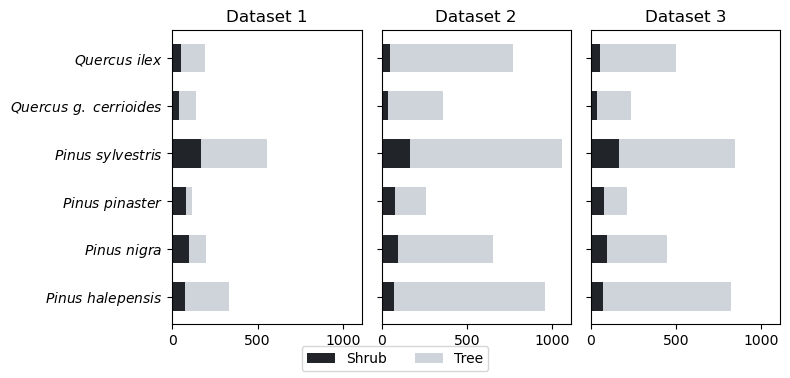

In [17]:
# Count of each class
bbox_label_groups = {
    r"$\it{Pinus\ halepensis}$": [1, 11],
    r"$\it{Pinus\ nigra}$": [2, 12],
    r"$\it{Pinus\ pinaster}$": [3, 13],
    r"$\it{Pinus\ sylvestris}$": [4, 14],
    # r"$\it{Pinus\ uncinata}$": [5],
    r"$\it{Quercus}\ g.\ \it{cerrioides}$": [6, 16],
    r"$\it{Quercus\ ilex}$": [7, 17]
}

species = list(bbox_label_groups.keys())
tree_groups = [g[0] for g in bbox_label_groups.values()]
shrub_groups = [g[1] for g in bbox_label_groups.values()]

# Dictionary to store groups which have been the bar levels
count_dict = {
    "Shrub": {"group": shrub_groups, "color": "#212529"},
    "Tree": {"group": tree_groups, "color": "#ced4da"}
}

height = 0.6  # the thickness of the bars

# One plot by dataset version
fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharey=True, sharex=True)

for v in range(3):

    dat_i = dat.query(dat_queries[v+1])
    # Spaces between bars
    left = np.zeros(len(species))

    for i, (lab, lab_group) in enumerate(count_dict.items()):

        group, color = lab_group.values()
        query = f"code_v1_reclass in [{','.join([str(v) for v in group])}]"
        d = dat_i.query(query)
        d_group = d.groupby(["code_v1_reclass"]).count()["ESPE"].sort_index()
        sp_count = d_group.values

        axs[v].barh(species, sp_count, height=height, color=color, left=left)
        # Add the next group of bars on top of the last ones
        left += sp_count

        axs[v].set_title(f"Dataset {v+1}")

# Create empty lists to store legend handles (colored patches) and labels
leg_handles, leg_labels = [], []

# Loop over category names and their associated colors
for label, l_dict in count_dict.items():

    # Create a dummy colored patch for the legend
    # (no need to actually plot bars — just create a representative box)
    leg_handles.append(Patch(facecolor=l_dict["color"], label=label))

    # Store the corresponding label for later use
    leg_labels.append(label)

# Create a global legend at the bottom of the figure
# - `leg_handles`: list of patches to show in the legend
# - `leg_labels`: corresponding text labels
# - `loc='best'`: place legend in the best position according to pyplot
# - `ncol=1`: ensure vertical layout
# - `title=''`: no legend title
fig.legend(leg_handles, leg_labels, loc='lower center', ncol=2, title='')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# plt.savefig(Path(graphics_path, f"labels_distribution.svg"))


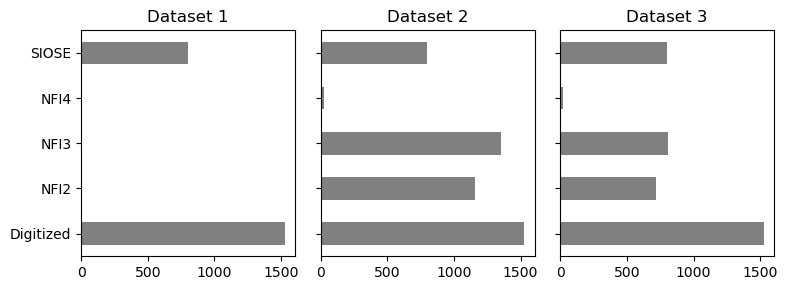

In [18]:
# One plot by dataset version
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True, sharex=True)

for v in range(1, 4):
    dat_i = dat.query(dat_queries[v])
    # Counting the species values giving the label source
    grpd = dat_i.groupby(["source"]).count()["ESPE"]
    # Temporal fix to the fact that dataset 1 only contains 2 labels
    if v == 1:
        new_rows = pd.Series([0] * 3, index=[f"NFI{i}" for i in range(2,5)])
        grpd = pd.concat([grpd, new_rows])
    
    (grpd
        .sort_index()
        .plot(kind='barh', color="grey", ax=axs[v-1], title=f"Dataset {v}")
    )

fig.tight_layout()

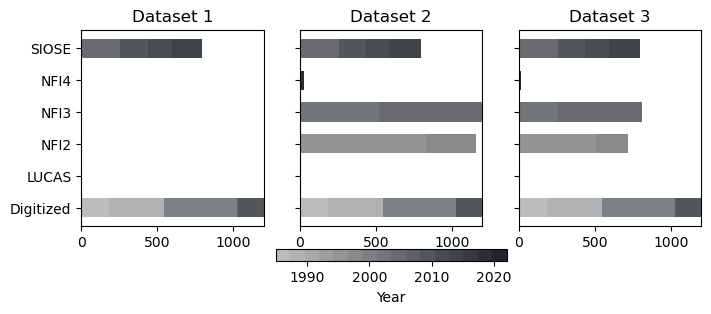

In [19]:
import matplotlib.colors as mcolors

# One plot by dataset version
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True, sharex=True)

dataset_sources = pd.unique(dat["source"])
years = sorted(pd.unique(dat["YEAR"]))
height = 0.6  # the thickness of the bars

# Create a colormap from grayscale colors
cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_grey",
    ["#bbbcbd", "#212529"],
    len(years)
)
colors = [cmap(i) for i in range(cmap.N)]
year_to_color = {year: colors[i] for i, year in enumerate(years)}

for v in range(1, 4):
    left = np.zeros(len(dataset_sources))

    dat_i = dat.query(dat_queries[v])

    for i, year in enumerate(years):

        if year not in pd.unique(dat_i["YEAR"]):
            continue
        query = f"YEAR == {year}"
        d = dat_i.query(query)
        d_group = d.groupby(["source"]).count()["ESPE"]
        # Not all the years contain the same sources
        # Add the current year values to a pandas of the sources with join
        temp_pd = pd.concat([
            pd.Series([0]*len(dataset_sources), index=dataset_sources),
            pd.Series(d_group.values, index=d_group.index, name="data"),
        ], axis=1).fillna(0).sort_index()
        axs[v-1].barh(
            temp_pd.index,
            temp_pd["data"],
            height=height,
            color=year_to_color[year],
            left=left)
        # Add the next group of bars on top of the last ones
        left += temp_pd["data"]

        axs[v-1].set_title(f"Dataset {v}")
        axs[v-1].set_xlim((0, 1200))

# ---- Gradient Legend ----
# Normalize years to the range [0,1] for color mapping
norm = mcolors.Normalize(vmin=min(years), vmax=max(years))

# Add a colorbar to illustrate the gradient
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # only needed for matplotlib < 3.2

cbar = fig.colorbar(
    sm,
    ax=axs,
    orientation="horizontal",
    fraction=0.05,
    pad=0.1
)
cbar.set_label("Year")
# fig.tight_layout(rect=[0, 0.02, 1, 0.95])
# plt.savefig(Path(graphics_path, f"dataset_versions.svg"))


## Outliers

After generating a Cleveland dot plot (Cleveland, 1993), the following anomalous values were observed:

- **NDVI**: Values below 0, typically associated with water, snow, clouds, or certain artificial surfaces.  
- **SWIR1 (spring)**: Values very close to or greater than 1, likely due to Landsat band errors or cloud contamination.  

All other values appear to fall within the expected ranges and accurately represent the land cover types.


In [20]:
# Boxplots of predictor variables
lcols = (dat.columns[dat.columns.str.endswith("summerlong")].to_list())
gcols = ['dem', 'shadow', 'slope', 'acibasi']

def print_dotplot(df, sorted_idx, col, ax, legend_groups):

    for group_name, group_dict in legend_groups.items():
        
        sorted_values = df.iloc[sorted_idx].query(group_dict["query"])[col]
    
        # Cleveland dotplot
        ax.plot(
            sorted_values,
            range(len(sorted_values)),
            "o",
            color=group_dict["color"])
    
    # Formatting
    ax.set_xlabel("Value")
    ax.set_ylabel("Observation (sorted index)")
    ax.grid(True, axis="x", linestyle="--", alpha=0.6)
    ax.set_title(col)

def dotplot_figure(df, version, lcols, gcols, nrows, ncols, output_path=None):

    fig, axs = plt.subplots(nrows, ncols, figsize = (10,10), sharey=True)

    # Transform landsat bands to reflectance
    pattern =  fr'^(?!NDVI_).*(summerlong)$'
    target_bands = df.columns.str.contains(pattern)
    df_ref = df.copy()
    df_ref.loc[:, target_bands] = df_ref.loc[:, target_bands] / 10000

    df_v = df_ref.query(dat_queries[version])
    # Select the first column to plot
    values = df_v["dem"]
    # Sort values for readability
    sorted_idx = values.argsort()

    # Store plot styles to create the graph legend
    leg_groups = {
        "Sparse vegetation": {"color": "#ACACAC", "query": "ESPE_rc == 20"},
        "Tree": {"color": "#666B6F", "query": "ESPE_rc < 10"},
        "Shrub": {"color": "#212529", "query": "(ESPE_rc > 10) and (ESPE_rc < 20)"}
    }

    for n, df_col in enumerate(lcols + gcols):

        # Integer division
        row = n // ncols
        # Division Remainder
        col = n % ncols

        print_dotplot(df_v, sorted_idx, df_col, axs[row, col], leg_groups)

    # Create a global legend
    leg_handles, leg_labels = [], []
    for label, properties in leg_groups.items():
        leg_handles.append(
            axs[0, 0].plot(
                [], [],
                # marker="o",
                color=properties['color'],
                linewidth=2,
                label=label
            )[0]
        )
        leg_labels.append(label)

    # Add global legend
    fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
    # Adjust layout to fit global legend
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    if output_path is not None:
        plt.savefig(output_path)

C:\Users\usuario\AppData\Local\Temp\ipykernel_7828\3751975061.py:30: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  target_bands = df.columns.str.contains(pattern)


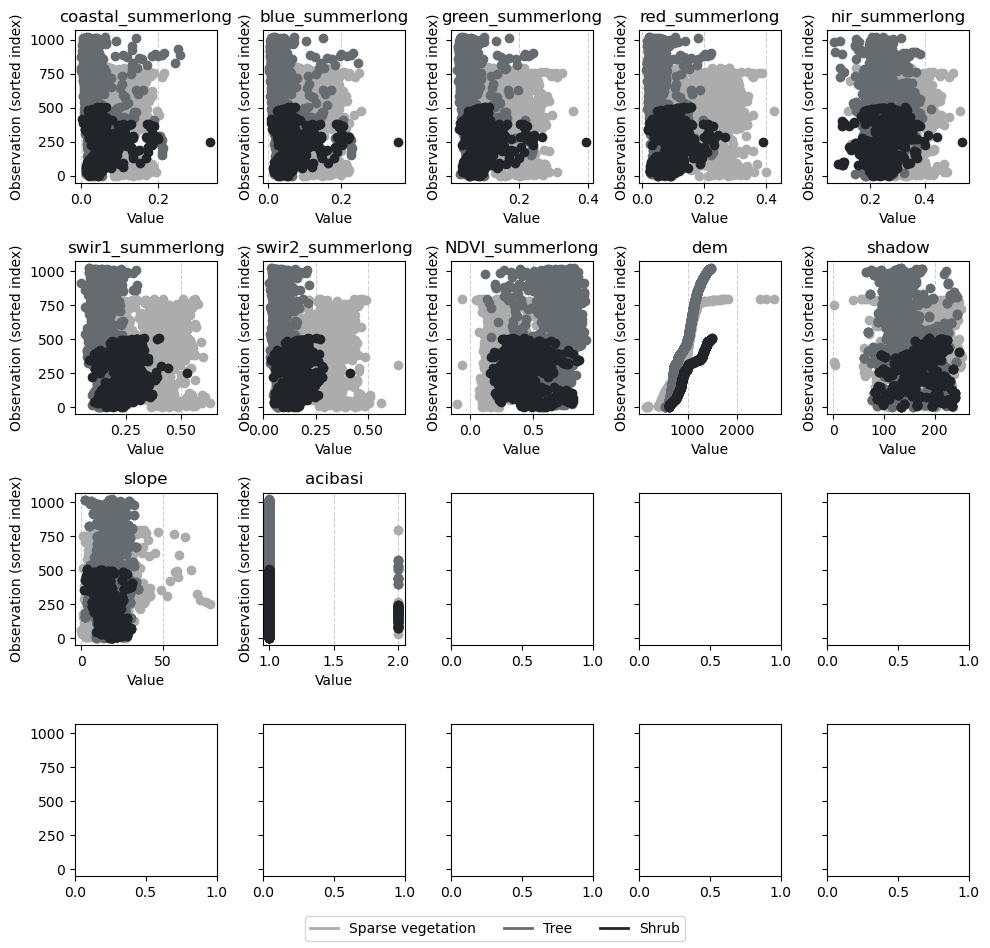

In [21]:
nrows = 4
ncols = 5

# outpath = Path(graphics_path, "cleveland_plot.svg")
dotplot_figure(dat, 1, lcols, gcols, nrows, ncols, output_path=None)

In [22]:
def drop_outliers(df):
    target = df.copy()
    # Likely water, snow, clouds, or some artificial surfaces.
    target.query("NDVI_summerlong > 0", inplace=True)
    target.query("coastal_summerlong < 4000", inplace=True)
    return target

dat[["NDVI_summerlong", "coastal_summerlong"]].describe()

,NDVI_summerlong,coastal_summerlong
count,5225.000000,5225.000000
mean,0.497941,483.086644
std,0.194523,380.520858
min,-0.099271,4.000000
25%,0.357408,255.000000
50%,0.515447,366.666660
75%,0.645828,549.000000
max,0.943844,3414.000000


In [23]:
drop_outliers(dat)[["NDVI_summerlong", "coastal_summerlong"]].describe()

,NDVI_summerlong,coastal_summerlong
count,5222.000000,5222.000000
mean,0.498270,482.717678
std,0.194093,380.282439
min,0.051139,4.000000
25%,0.357503,255.000000
50%,0.515560,366.431825
75%,0.645918,548.249975
max,0.943844,3414.000000


In [24]:
dat_without_out = drop_outliers(dat)

## Behavior of Predictor Variables

For each dataset version, an analysis of the predictor variables was carried out. All three versions of the dataset exhibit an imbalanced sample distribution.


### Landsat bands

In [ ]:
def ref_plot(df, version):
    # Transform values to reflectance in order to get
    # a better representation of the spec. sign.
    lcols = (df.columns.str.endswith("summerlong"))

    dat_ref = df.copy().query(dat_queries[version])
    # Note: A scale factor has been applied to the predictor labels.
    dat_ref.loc[:, lcols] = dat_ref.loc[:, lcols] / 10000

    # Compute plots by tree, shrub and bare ground
    spectral_sign_splits = {
        'Trees': [1, 2, 3, 4, 5, 6, 7],
        'Shrubs': [11, 12, 13, 14, 16, 17],
        'Bare soil': [20]
    }

    # Three rows (summer, spring and summer long) and three cols
    # (three spectral signature split types).
    fig, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(13,4))

    veg_styles = {
        # Obligate seeders
        r"$\it{Pinus\ halepensis}$": {'color': "#525252", 'linestyle': '-'},
        r"$\it{Pinus\ pinaster}$": {'color': "#969696", 'linestyle': '-'},
        # Passive defense systems
        r"$\it{Pinus\ nigra}$": {'color': "#525252", 'linestyle': '-.'},
        r"$\it{Pinus\ sylvestris}$": {'color': "#969696", 'linestyle': '-.'},
        # 'Pinus uncinata': {'color': "#cccccc", 'linestyle': '-.'},
        # Obligate resprouters
        r"$\it{Quercus}\ g.\ \it{cerrioides}$": {'color': "#525252", 'linestyle': '--'},
        r"$\it{Quercus\ ilex}$": {'color': "#969696", 'linestyle': '--'}
    }

    shrub_styles = veg_styles.copy()
    # Remove the Pinus uncinata
    # del shrub_styles['Pinus uncinata']

    bare_g_style = {
        "Sparse vegetation": {'color': "#212529", "linestyle": "-"}
    }

    for i, (ss_name, ss_codes) in enumerate(spectral_sign_splits.items()):

        if len(ss_codes) > 1:
            q = f"code_v1_reclass in ({",".join(map(str, ss_codes))})"
        else:
            q = f"code_v1_reclass == 20"

        if ss_name == "Trees":
            styles = veg_styles
        elif ss_name == "Shrubs":
            styles = shrub_styles
        else:
            styles = bare_g_style

        df = dat_ref.query(q)

        # Summerlong values are the same as summer
        for z, season in enumerate(["summerlong"]):

            pattern =  fr'^(?!NDVI_).*{season}$'

            plot_cols = df.columns[df.columns.str.contains(pattern)].to_list()
            grp = df[
                plot_cols + ["label_reclass"]].groupby('label_reclass').mean()

            # Extract band names without season suffix
            plot_cols = [c.split("_")[0] for c in plot_cols]
            for e, (label_values, row) in enumerate(grp.iterrows()):

                # axs[z, i].plot(
                axs[i].plot(
                    plot_cols,
                    row,
                    # marker="o",
                    label=label_values,
                    color= [d['color'] for d in styles.values()][e],
                    linestyle = [d['linestyle'] for d in styles.values()][e]
                )

                axs[i].set_xlabel("Wavelength")
                axs[i].set_ylabel(f"Ref. {season}")
                axs[i].grid(True)


    # Create a global legend
    leg_handles, leg_labels = [], []
    for label, properties in {**veg_styles, **bare_g_style}.items():
        leg_handles.append(
            axs[0].plot(
                [], [],
                # marker="o",
                color=properties['color'],
                linestyle=properties['linestyle'],
                label=label
            )[0]
        )
        leg_labels.append(label)

    # Add global legend
    fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
    # Adjust layout to fit global legend
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

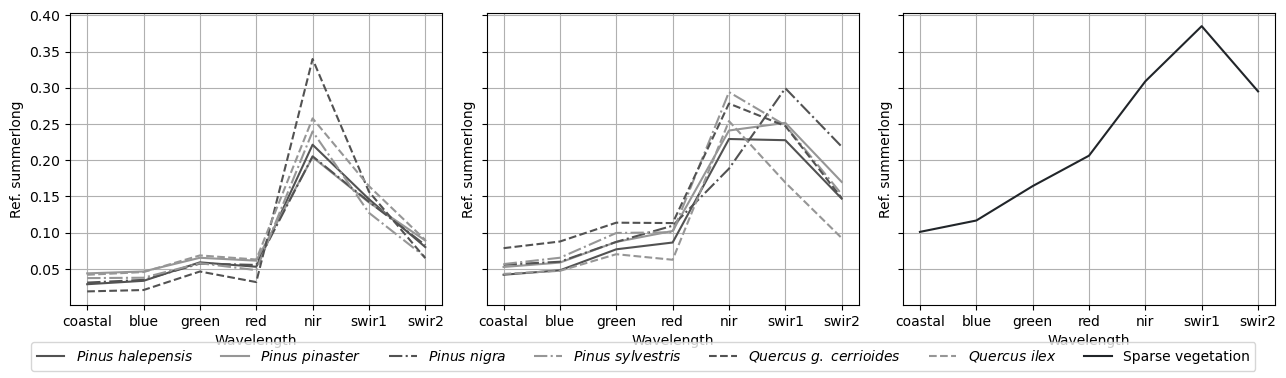

In [26]:
ref_plot(dat, 1)

IndexError: list index out of range

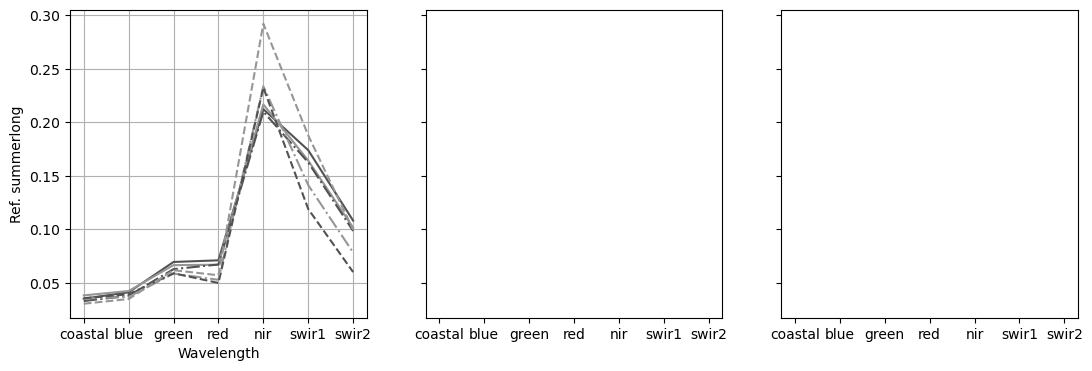

In [28]:
ref_plot(dat, 2)

In [ ]:
ref_plot(dat, 3)

#### Spectral signatures miniplots

Generate small plots showing the spectral signature of a species and its shrubland.


In [ ]:
def ref_mini_plot(df, tree, shrub, outpath = None):
    # Transform values to reflectance in order to get
    # a better representation of the spec. sign.
    lcols = (
        df.columns.str.endswith("summer")
        | df.columns.str.endswith("spring")
    )
    dat_ref = df.copy()
    dat_ref.loc[:, lcols] = df.loc[:, lcols] / 10000

    # Three rows (summer, spring and summer long) and three cols
    # (three spectral signature split types).
    fig, ax = plt.subplots(1, 1, figsize=(3,3))

    # Summer signature
    pattern =  fr'^(?!NDVI_).*summer$'
    plot_cols = dat_ref.columns[dat_ref.columns.str.contains(pattern)]
    plot_reduced_cols = plot_cols.to_list() + ["label_reclass"]
    
    # Tree spectre
    q = f"code_v1_reclass == {tree}"
    dat_ref_tree = dat_ref.query(q)
    grp = dat_ref_tree[plot_reduced_cols].groupby('label_reclass').mean()
    tree_vals = grp.iloc[0, :].values
    # Shrub spectre
    q = f"code_v1_reclass == {shrub}"
    dat_ref_shrub = dat_ref.query(q)
    grp = dat_ref_shrub[plot_reduced_cols].groupby('label_reclass').mean()
    shrub_vals = grp.iloc[0,:].values

    # Extract band names without season suffix
    plot_col_names = ["C", "B", "G", "R", "N", "SW1", "SW2"]

    ax.plot(
        plot_col_names,
        tree_vals,
        marker="o",
        linestyle="-",
        label="Tree",
        color= "#525252"
    )

    ax.plot(
        plot_col_names,
        shrub_vals,
        marker="o",
        label="Shrub",
        linestyle="--",
        color= "#525252"
    )

    # ax.set_xlabel("Wavelength")
    ax.set_ylabel("Average summer reflectance")
    ax.grid(True)
    ax.set_ylim(0, .4)
    ax.set_yticks((0, .1, .2, .3, .4))

    # Create a global legend
    leg_handles, leg_labels = [], []
    for label, linestyle in zip(["Tree", "Shrub"], ["-", "--"]):
        leg_handles.append(
            ax.plot(
                [], [],
                # marker="o",
                color="#525252",
                linestyle=linestyle,
                label=label
            )[0]
        )
        leg_labels.append(label)

    # Add global legend
    # fig.legend(leg_handles, leg_labels, loc='lower center', ncol=8, title='')
    # Adjust layout to fit global legend
    # fig.tight_layout(rect=[0, 0.04, 1, 0.95])
    fig.tight_layout()

    if outpath is not None:
        plt.savefig(Path(outpath, f"ref_miniplot_{tree}_vs_{shrub}.svg"))

In [ ]:
# for i in [1, 2, 3, 4, 6, 7]:
    # ref_mini_plot(dat_without_out.query(dat_queries[1]), i, i+10, graphics_path)

### Global Predictors and Indices

In [ ]:
nrows = 2
ncols = 3

# Function to color boxplot
def set_box_colors(bp, colors):
    for patch in bp['boxes']:
        patch.set(color=colors["box"])
    for whisker in bp['whiskers']:
        whisker.set(color=colors["whisker"], linewidth=1.5)
    for cap in bp['caps']:
        cap.set(color=colors["cap"], linewidth=1.5)
    for median in bp['medians']:
        median.set(color=colors["median"], linewidth=2)
    for flier in bp['fliers']:
        flier.set(
            markerfacecolor=colors["flier"],
            markeredgecolor=colors["flier"],
            marker='o',
            alpha=1
        )

def create_boxplot(df, pred_vars, ncols, nrows):

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10), sharey=True)

    bbox_label_groups = {
        r"$\it{Pinus\ halepensis}$": [1, 11],
        r"$\it{Pinus\ nigra}$": [2, 12],
        r"$\it{Pinus\ pinaster}$": [3, 13],
        r"$\it{Pinus\ sylvestris}$": [4, 14],
        # r"$\it{Pinus\ uncinata}$": [5],
        r"$\it{Quercus}\ g.\ \it{cerrioides}$": [6, 16],
        r"$\it{Quercus\ ilex}$": [7, 17],
        r"$\it{Sparse\ vegetation}$": [20]
    }

    box_width = 0.3

    # Custom colors for box1
    shrub_boxs = {
        "box": "#969696",
        "whisker": "#969696",
        "cap": "#969696",
        "median": "#969696",
        "flier": "#969696"
    }

    # Custom colors for box2
    veg_boxs = {
        "box": "#212529",
        "whisker": "#212529",
        "cap": "#212529",
        "median": "#212529",
        "flier": "#212529"
    }

    for n, var in enumerate(pred_vars):

        # Integer division
        row = n // ncols
        # Division Remainder
        col = n % ncols

        # Split between shrub and trees (and sparse veg)
        for i, (_, lbl_groups) in enumerate(bbox_label_groups.items()):
            
            query_str = "code_v1_reclass == {}"
            
            if len(lbl_groups) == 1:
                data = df.query(query_str.format(lbl_groups[0]))[var]

                box = axs[row, col].boxplot(
                    data,
                    positions=[i+1],
                    widths=box_width,
                    vert=False
                    # orientation="horizontal"
                )
                
                set_box_colors(box, veg_boxs)

            else:
                data = df.query(query_str.format(lbl_groups[0]))[var]
                # Shift the two boxplots slightly left and right of
                # the same group to plot both together
                box1 = axs[row, col].boxplot(
                    data,
                    positions=[(i + 1) - box_width / 2],
                    widths=box_width,
                    vert=False
                    # orientation="horizontal"
                )

                data = df.query(query_str.format(lbl_groups[1]))[var]
                box2 = axs[row, col].boxplot(
                    data,
                    positions=[(i+1) + box_width / 2], 
                    widths=box_width,
                    vert=False
                    # orientation="horizontal"
                )

                # Apply colors
                set_box_colors(box1, veg_boxs)
                set_box_colors(box2, shrub_boxs)

        # Now only set one xtick at the group position
        axs[row, col].set_yticks([z + 1 for z in range(len(bbox_label_groups))])
        axs[row, col].set_yticklabels(bbox_label_groups.keys())
        axs[row, col].grid(True)
        axs[row, col].set_title(var)


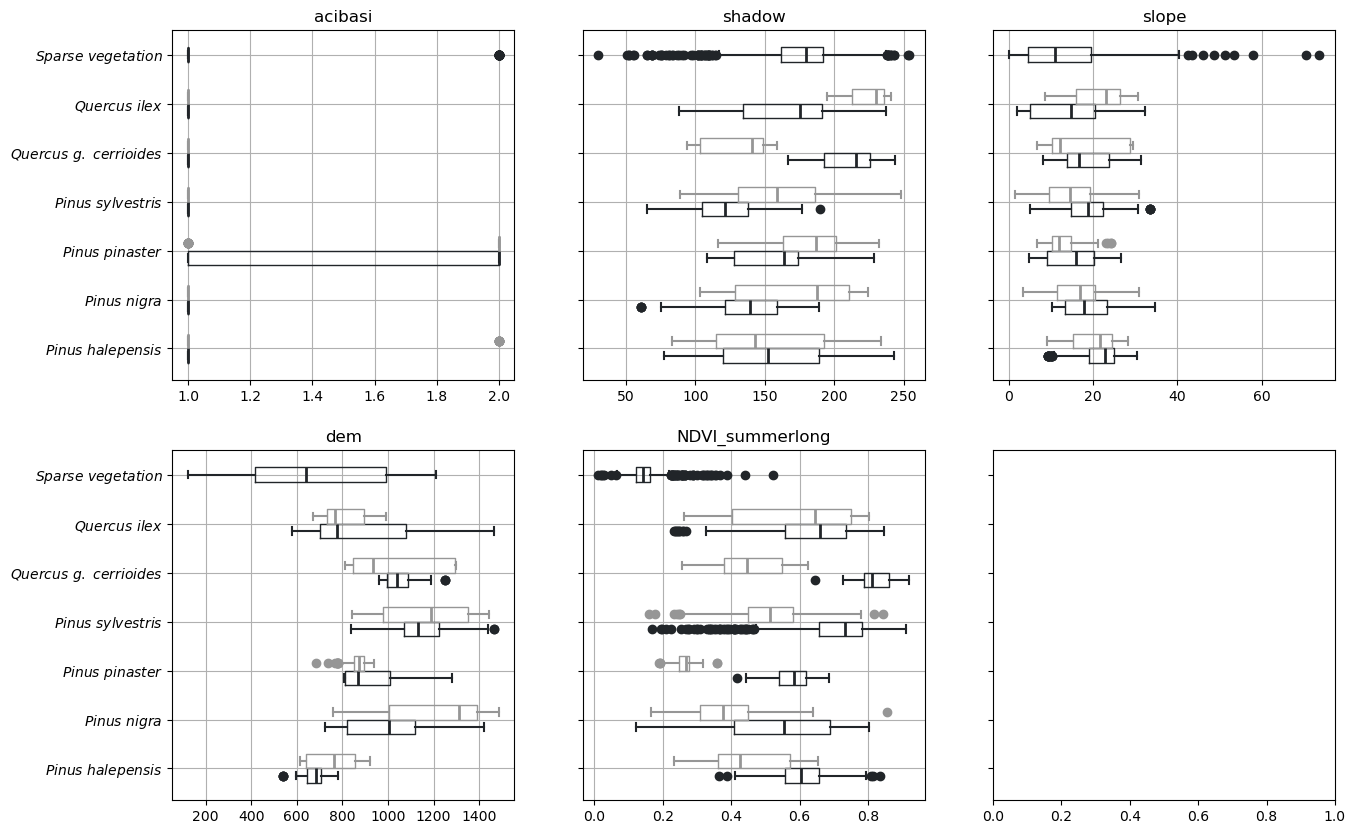

In [ ]:
bbox_vars = ["acibasi", "shadow", "slope", "dem", "NDVI_summerlong"]

create_boxplot(dat_without_out.query(dat_queries[1]), bbox_vars, ncols, nrows)

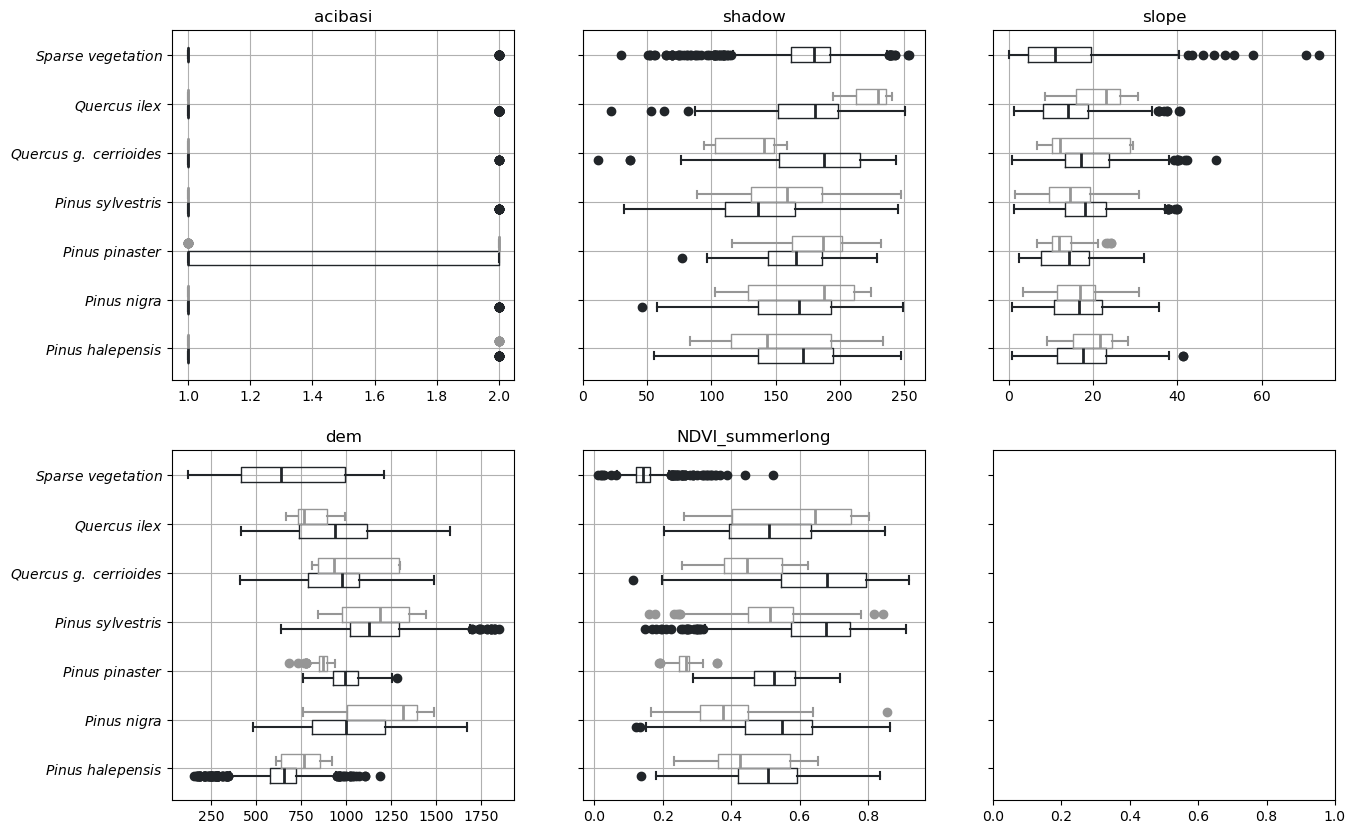

In [ ]:
create_boxplot(dat_without_out.query(dat_queries[2]), bbox_vars, ncols, nrows)

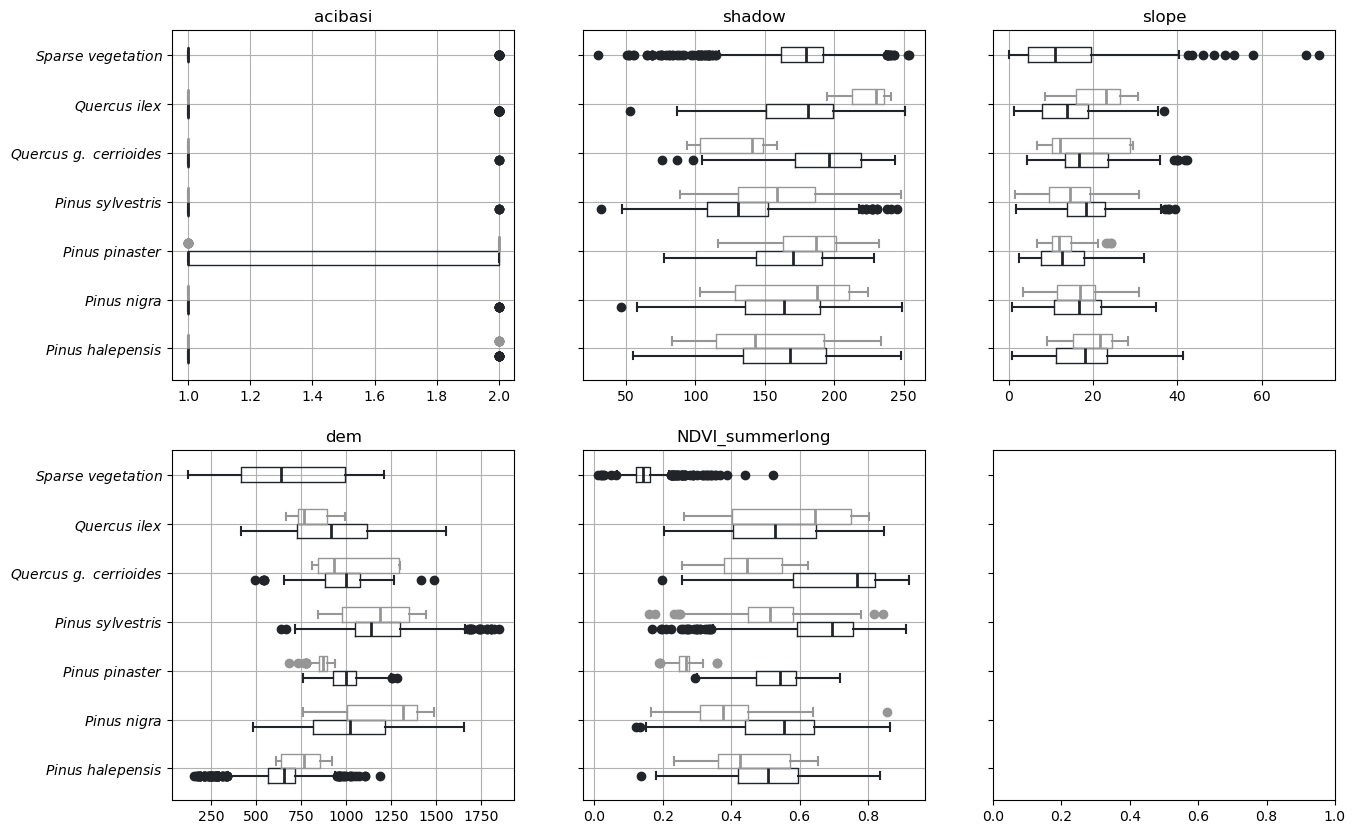

In [ ]:
create_boxplot(dat_without_out.query(dat_queries[3]), bbox_vars, ncols, nrows)

#### Construct PCA from summer and spring variables

In [ ]:
def reduction(df, columns, suffix):

    # Standardize predictors (mean=0, variance=1) before PCA
    X = StandardScaler().fit_transform(df[columns])

    # Fit PCA with 3 components
    pca = PCA(n_components=3, random_state=42)
    pca.fit(X)

    # Apply PCA transformation to predictors (NumPy array)
    pca_np = pca.transform(X)

    # Create readable names for PCA components
    pca_cols = ['PCA%i' % i for i in range(1, pca.n_components_ + 1)]
    pca_cols = [n + '_' + suffix for n in pca_cols]

    # Convert PCA results into a DataFrame with proper column names
    return pd.DataFrame(pca_np, columns=pca_cols, index=df.index)

version = 1
summerlong_pcas = reduction(
    dat_without_out.query(dat_queries[version]),
    dat.columns[dat.columns.str.endswith("summerlong")],
    "summerlong")
global_pcas = reduction(
    dat_without_out.query(dat_queries[version]),
    ["shadow", "dem", "slope"],
    "global")

pcas_df = pd.concat([
    summerlong_pcas,
    global_pcas,
    dat_without_out.query(dat_queries[version])["code_v1_reclass"]], axis=1)

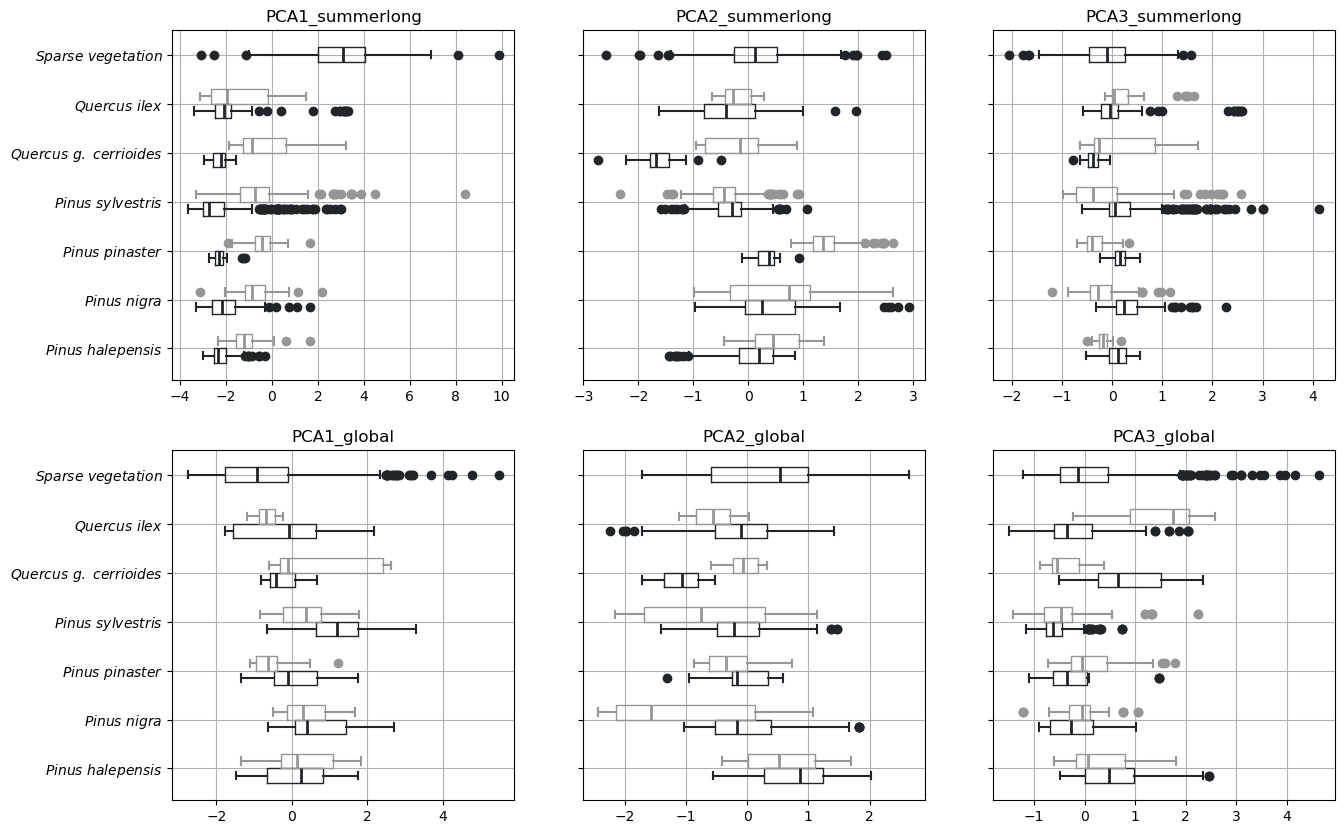

In [ ]:
create_boxplot(
    pcas_df,
    pcas_df.columns[pcas_df.columns.str.startswith("PCA")], 3, 2)

## Collinearity Among Predictor Variables

The correlation between variables was calculated using the `corr` method in pandas.

It was also tested with [SciPy using permutations](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html), but this approach required considerably more computation time.

> Although the calculation of the p-value does not make strong assumptions about the distributions underlying the samples, it is only accurate for very large samples (>500 observations). For smaller sample sizes, consider using a permutation test.

[^1]: [Visualization of correlation](https://realpython.com/numpy-scipy-pandas-correlation-python/#visualization-of-correlation)  
[^2]: [Detecting Multicollinearity with VIF](https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/)  
[^3]: [How to Test Multicollinearity](https://www.statology.org/multicollinearity-in-python/)  
[^4]: [Plot Correlation Matrix Using pandas](https://stackoverflow.com/a/50703596/23551600)  


In [ ]:
corr_cols = (
    dat.columns.str.endswith("summerlong")
    | dat.columns.isin(["shadow", "slope", "dem"])
)
corr = (dat_without_out
    .query(dat_queries[3])
    .loc[:, corr_cols]
    .corr(method='spearman')
)
corr.style.background_gradient(
    cmap='coolwarm',
    vmin=-1,
    vmax=1).format(precision=2)

,coastal_summerlong,blue_summerlong,green_summerlong,red_summerlong,nir_summerlong,swir1_summerlong,swir2_summerlong,dem,shadow,slope,NDVI_summerlong
coastal_summerlong,1.00,0.98,0.93,0.91,0.51,0.82,0.83,-0.25,0.14,-0.21,-0.88
blue_summerlong,0.98,1.00,0.97,0.95,0.52,0.85,0.85,-0.27,0.15,-0.21,-0.90
green_summerlong,0.93,0.97,1.00,0.98,0.59,0.89,0.89,-0.30,0.18,-0.23,-0.91
red_summerlong,0.91,0.95,0.98,1.00,0.51,0.93,0.95,-0.29,0.21,-0.26,-0.96
nir_summerlong,0.51,0.52,0.59,0.51,1.00,0.60,0.49,-0.09,0.11,-0.16,-0.31
swir1_summerlong,0.82,0.85,0.89,0.93,0.60,1.00,0.98,-0.23,0.28,-0.28,-0.86
swir2_summerlong,0.83,0.85,0.89,0.95,0.49,0.98,1.00,-0.25,0.27,-0.29,-0.92
dem,-0.25,-0.27,-0.30,-0.29,-0.09,-0.23,-0.25,1.00,-0.08,0.14,0.31
shadow,0.14,0.15,0.18,0.21,0.11,0.28,0.27,-0.08,1.00,-0.30,-0.20
slope,-0.21,-0.21,-0.23,-0.26,-0.16,-0.28,-0.29,0.14,-0.30,1.00,0.25


In [ ]:
pcas_df.corr(method="spearman").style.background_gradient(
    cmap='coolwarm',
    vmin=-1,
    vmax=1).format(precision=2)

,PCA1_summerlong,PCA2_summerlong,PCA3_summerlong,PCA1_global,PCA2_global,PCA3_global,code_v1_reclass
PCA1_summerlong,1.00,0.09,-0.12,-0.48,0.13,0.08,0.82
PCA2_summerlong,0.09,1.00,0.05,-0.05,0.14,0.17,0.11
PCA3_summerlong,-0.12,0.05,1.00,0.16,0.26,-0.02,-0.24
PCA1_global,-0.48,-0.05,0.16,1.00,0.00,-0.04,-0.46
PCA2_global,0.13,0.14,0.26,0.00,1.00,0.11,0.03
PCA3_global,0.08,0.17,-0.02,-0.04,0.11,1.00,0.05
code_v1_reclass,0.82,0.11,-0.24,-0.46,0.03,0.05,1.00


In [ ]:
pd.concat([
    summerlong_pcas,
    dat_without_out[["dem", "slope", "shadow"]]
], axis=1).corr(method="spearman").style.background_gradient(
    cmap='coolwarm',
    vmin=-1,
    vmax=1).format(precision=2)

,PCA1_summerlong,PCA2_summerlong,PCA3_summerlong,dem,slope,shadow
PCA1_summerlong,1.00,0.09,-0.12,-0.36,-0.35,0.31
PCA2_summerlong,0.09,1.00,0.05,-0.18,0.03,0.02
PCA3_summerlong,-0.12,0.05,1.00,-0.12,0.16,-0.27
dem,-0.36,-0.18,-0.12,1.00,0.09,-0.06
slope,-0.35,0.03,0.16,0.09,1.00,-0.28
shadow,0.31,0.02,-0.27,-0.06,-0.28,1.00


### Variance Inflation Factor

> [...] sequentially drop the covariate with the highest VIF, recalculate the VIFs and repeat this process until all VIFs are smaller than a pre-selected threshold. Montgomery & Peck (1992) used a value of 10, but a more stringent approach is to use values as low as 3 as we did here. High, or even moderate, collinearity is especially problematic when ecological signals are weak. In that case, even a VIF of 2 may cause nonsignificant parameter estimates, compared to the situation without collinearity.



https://stackoverflow.com/q/42658379/23551600

In [ ]:
def compute_vifs(df):
    return pd.Series(np.linalg.inv(df.to_numpy()).diagonal(), 
                 index=df.columns, 
                 name='VIF')

def best_predictors(df, dat_query, corr_cols, threshold = 3):
    """Remove variables with the highest VIF one by one until anyone are higher than threshold"""

    corr = df.query(dat_query).loc[:, corr_cols].corr(method='spearman')
    # Compute VIFs for the first time
    vif = compute_vifs(corr)

    # Create a copy of the dataframe to remove invalid variables
    new_df = corr.copy()

    while vif.max() > threshold:
        # Remove the predictor with the maximum value
        max_vif_idx = vif.idxmax()
        new_df = new_df.drop(max_vif_idx).drop(max_vif_idx, axis=1)
        # Recompute vif values
        vif = compute_vifs(new_df)

    return vif

In [ ]:
corr_cols = (
    dat_without_out.columns.str.endswith("summerlong")
    | dat_without_out.columns.isin(["shadow", "slope", "dem"])
)
for i in [1, 2, 3]:
    print(f"VIF {i}")
    print(best_predictors(dat_without_out, dat_queries[i], corr_cols))

VIF 1
coastal_summerlong    1.880996
nir_summerlong        1.747154
dem                   1.178599
shadow                1.187207
slope                 1.228969
Name: VIF, dtype: float64
VIF 2
coastal_summerlong    1.316796
nir_summerlong        1.256290
dem                   1.041149
shadow                1.101568
slope                 1.136603
Name: VIF, dtype: float64
VIF 3
coastal_summerlong    1.457983
nir_summerlong        1.360246
dem                   1.077715
shadow                1.110420
slope                 1.147681
Name: VIF, dtype: float64


In [ ]:
corr_cols = pcas_df.columns[pcas_df.columns.str.startswith("PCA")]
dat_with_pca = pd.concat([
    dat_without_out.query(dat_queries[1]),
    pcas_df.loc[:, corr_cols]
], axis=1)

print(f"VIF pca 1")
print(best_predictors(dat_with_pca, dat_queries[1], corr_cols))

VIF pca 1
PCA1_summerlong    1.341112
PCA2_summerlong    1.049756
PCA3_summerlong    1.118202
PCA1_global        1.318688
PCA2_global        1.132863
PCA3_global        1.042173
Name: VIF, dtype: float64


In [ ]:
corr_cols = pcas_df.columns[pcas_df.columns.str.startswith("PCA")]
dat_with_pca = pd.concat([
    dat_without_out.query(dat_queries[1]),
    pcas_df.loc[:, corr_cols]
], axis=1)
corr_cols = (
    dat_with_pca.columns.str.endswith("summerlong")
    | dat_with_pca.columns.str.endswith("global")
    | dat_with_pca.columns.isin(["shadow", "slope", "dem"])
)
print(f"VIF global 1")
print(best_predictors(dat_with_pca, dat_queries[1], corr_cols))

VIF global 1
coastal_summerlong    1.288351
dem                   1.216035
shadow                1.256598
slope                 1.244589
PCA2_summerlong       1.042972
PCA3_summerlong       1.156287
Name: VIF, dtype: float64
